In [9]:
import pandas as pd
import numpy as np
import math 
import json
import seaborn
import matplotlib.pyplot as plt
from datetime import datetime

rawdata = pd.read_csv("experimentData/full.csv", sep=",")

num_rounds = 10
num_trials = 20
gridSize_0 = 7

# Remove empty rows
rawdata = rawdata[np.logical_and(np.logical_not(rawdata["grid_assignmentID"].isna()), np.logical_not(rawdata["gabor_assignmentID"].isna()))]

normalise = True
sampleSize = len(rawdata)
all_opts = [(x, y) for y in range(gridSize_0+1) for x in range(gridSize_0+1)]
columns = ["id","age","gender","environment","contextOrder","context","round","trial","x","y","chosen","initx","inity","trajectories","steps","movement","distance","distance_x","distance_y","z","zscaled","previousReward","ts","scale","envOrder","bonus","totalBonus","trajCorrect","trajRMSE","trajAvgSteps","grid_start","grid_end","grid_duration","gabor_start","gabor_end","gabor_duration","grid_gabor_gap","comprehensionTries"]
df = pd.DataFrame(columns=columns)

for i in range(sampleSize):
    dat = rawdata.iloc[i,:]
    
    Id = dat["id"]
    age = dat["grid_age"]
    gender = dat["grid_gender"]
    environment = dat["environment"]
    contextOrder = dat["scenario"]
    gridBonus = dat["grid_reward"]
    gaborBonus = dat["gabor_reward"]
    totalBonus = gridBonus + gaborBonus
    
    # Spatial stimuli
    gridHistory = json.loads(str(dat["grid_experimentData"]))
    gridComprehensionTries = gridHistory["comprehensionQuestionTries"]
    grid_x = [x for l in gridHistory["xcollect"] for x in l]
    grid_y = [x for l in gridHistory["ycollect"] for x in l]
    initValues = [x for l in gridHistory["initcollect"] for x in l]
    grid_initx = [x[0] for l in gridHistory["initcollect"] for x in l if x!=None]
    grid_initx = grid_initx[0:195] + [np.nan] + grid_initx[195:199]
    grid_inity = [x[1] for l in gridHistory["initcollect"] for x in l if x!=None]
    grid_inity = grid_inity[0:195] + [np.nan] + grid_inity[195:199]
    grid_chosen = [grid_x[i] + 8*grid_y[i] for i in range(len(grid_x))]
    grid_ts = [x for l in gridHistory["tscollect"] for x in l]
    grid_z = [x for l in gridHistory["zcollect"] for x in l]
    if normalise == True:
        grid_z = [(x-50)/100 for x in grid_z] 
    grid_zscaled = [x for l in gridHistory["zscaledcollect"] for x in l]
    grid_previousz = [np.nan] + grid_z[0:-1]
    gridScale = gridHistory["scaleCollect"][0:num_rounds]
    if 'envOrder' in gridHistory.keys():
        gridEnvOrder = [y for l in [[x]*num_trials for x in gridHistory["envOrder"]] for y in l]
    else:
        gridEnvOrder = [np.nan]*num_rounds*num_trials
    grid_delta_x = abs(np.reshape(grid_x, (num_trials, num_rounds), order="F")[0:num_trials-1] - np.reshape(grid_x, (num_trials, num_rounds), order="F")[1:num_trials])
    grid_delta_y = abs(np.reshape(grid_y, (num_trials, num_rounds), order="F")[0:num_trials-1] - np.reshape(grid_y, (num_trials, num_rounds), order="F")[1:num_trials])
    gridDistance = grid_delta_x + grid_delta_y
    gridDistance = [x for l in np.reshape(np.vstack([[np.nan]*num_rounds, gridDistance]), (num_trials*num_rounds,1), order="F").tolist() for x in l]
    grid_movement_x = abs(np.reshape(grid_x, (num_trials, num_rounds), order="F") - np.reshape(grid_initx, (num_trials, num_rounds), order="F"))
    grid_movement_y = abs(np.reshape(grid_y, (num_trials, num_rounds), order="F") - np.reshape(grid_inity, (num_trials, num_rounds), order="F"))
    gridMovement = [x for l in np.reshape((grid_movement_x + grid_movement_y), (1, num_trials*num_rounds), order="F") for x in l]
    grid_trajectories = [x for l in gridHistory["stepcollect"] for x in l]
    grid_steps = [np.size(x) for x in grid_trajectories]
    gridTraj = gridHistory["trajCollect"]
    gridTrajError = np.sum((np.asarray(gridTraj["targetcollect"])-np.asarray(gridTraj["selectioncollect"]))**2, axis=1)
    gridTrajCorrect = np.sum(gridTrajError == 0) / np.size(gridTrajError)
    gridTrajRMSE = np.sqrt(np.sum(gridTrajError))
    gridTrajAvgSteps = np.mean([len(x) for x in gridTraj["stepcollect"]])
    
    # Conceptual stimuli
    gaborHistory = json.loads(str(dat["gabor_experimentData"]))
    gaborComprehensionTries = gaborHistory["comprehensionQuestionTries"]
    gabor_x = [x for l in gaborHistory["xcollect"] for x in l]
    gabor_y = [x for l in gaborHistory["ycollect"] for x in l]
    initValues = [x for l in gaborHistory["initcollect"] for x in l]
    gabor_initx = [x[0] for l in gaborHistory["initcollect"] for x in l if x!=None]
    gabor_initx = gabor_initx[0:195] + [np.nan] + gabor_initx[195:199]
    gabor_inity = [x[1] for l in gaborHistory["initcollect"] for x in l if x!=None]
    gabor_inity = gabor_inity[0:195] + [np.nan] + gabor_inity[195:199]
    gabor_chosen = [gabor_x[i] + 8*gabor_y[i] for i in range(len(gabor_x))]
    gabor_ts = [x for l in gaborHistory["tscollect"] for x in l]
    gabor_z = [x for l in gaborHistory["zcollect"] for x in l]
    if normalise == True:
        gabor_z = [(x-50)/100 for x in gabor_z] 
    gabor_zscaled = [x for l in gaborHistory["zscaledcollect"] for x in l]
    gabor_previousz = [np.nan] + gabor_z[0:-1]
    gaborScale = gaborHistory["scaleCollect"][0:num_rounds]
    if 'envOrder' in gaborHistory.keys():
        gaborEnvOrder = [y for l in [[x]*num_trials for x in gaborHistory["envOrder"]] for y in l]
    else:
        gaborEnvOrder = [np.nan]*num_rounds*num_trials
    gabor_delta_x = abs(np.reshape(gabor_x, (num_trials, num_rounds), order="F")[0:num_trials-1] - np.reshape(gabor_x, (num_trials, num_rounds), order="F")[1:num_trials])
    gabor_delta_y = abs(np.reshape(gabor_y, (num_trials, num_rounds), order="F")[0:num_trials-1] - np.reshape(gabor_y, (num_trials, num_rounds), order="F")[1:num_trials])
    gaborDistance = gabor_delta_x + gabor_delta_y
    gaborDistance = [x for l in np.reshape(np.vstack([[np.nan]*num_rounds, gaborDistance]), (num_trials*num_rounds,1), order="F").tolist() for x in l]
    gabor_movement_x = abs(np.reshape(gabor_x, (num_trials, num_rounds), order="F") - np.reshape(gabor_initx, (num_trials, num_rounds), order="F"))
    gabor_movement_y = abs(np.reshape(gabor_y, (num_trials, num_rounds), order="F") - np.reshape(gabor_inity, (num_trials, num_rounds), order="F"))
    gaborMovement = [x for l in np.reshape((gabor_movement_x + gabor_movement_y), (1, num_trials*num_rounds), order="F") for x in l]
    gabor_trajectories = [x for l in gaborHistory["stepcollect"] for x in l]
    gabor_steps = [np.size(x) for x in gabor_trajectories]
    gaborTraj = gaborHistory["trajCollect"]
    gaborTrajError = np.sum((np.asarray(gaborTraj["targetcollect"])-np.asarray(gaborTraj["selectioncollect"]))**2, axis=1)
    gaborTrajCorrect = np.sum(gaborTrajError == 0) / np.size(gaborTrajError)
    gaborTrajRMSE = np.sqrt(np.sum(gaborTrajError))
    gaborTrajAvgSteps = np.mean([len(x) for x in gaborTraj["stepcollect"]])
    
    # Round and trial data
    rnd = [y for l in [[x]*num_trials for x in range(num_rounds)] for y in l]*2
    trial = [y for y in [x for x in range(num_trials)]*num_rounds*2]
    n = len(trial) 
    
    # Start and end times
    if type(dat["grid_task_start"]) == str:
        grid_start = datetime.strptime(str(dat["grid_task_start"]),"%Y-%m-%d %H:%M")
        grid_end = datetime.strptime(str(dat["grid_task_end"]),"%Y-%m-%d %H:%M")
        grid_duration = grid_end - grid_start
    else:
        grid_start = np.nan
        grid_end = np.nan
        grid_duration = np.nan
    
    if type(dat["gabor_task_start"]) == str:
        gabor_start = datetime.strptime(str(dat["gabor_task_start"]),"%Y-%m-%d %H:%M")
        gabor_end = datetime.strptime(str(dat["gabor_task_end"]),"%Y-%m-%d %H:%M")
        gabor_duration = gabor_end - gabor_start
    else:
        gabor_start = np.nan
        gabor_end = np.nan
        gabor_duration = np.nan
    
    if type(dat["grid_task_start"]) == str and type(dat["gabor_task_start"]) == str:
        if gabor_start > grid_start:
            grid_gabor_gap = gabor_start - grid_end
        else:
            grid_gabor_gap = grid_start - gabor_end
    else:
        grid_gabor_gap = np.nan
        
    df = df.append({"id": [Id]*n, 
                          "age": [age]*n, 
                          "gender": [gender]*n, 
                          "environment": [environment]*n, 
                          "contextOrder": [contextOrder]*n,
                          "context": ["Spatial"]*(int(n/2)) +  ["Conceptual"]*(int(n/2)),
                          "round": rnd,
                          "trial": trial,
                          "x": grid_x + gabor_x,
                          "y": grid_y + gabor_y,
                          "chosen": grid_chosen + gabor_chosen,
                          "initx": grid_initx + gabor_initx,
                          "inity": grid_inity + gabor_inity,
                          "trajectories": grid_trajectories + gabor_trajectories,
                          "steps": grid_steps + gabor_steps,
                          "movement": gridMovement + gaborMovement,
                          "distance": gridDistance + gaborDistance,
                          "distance_x": np.reshape(np.vstack([[np.nan]*num_rounds, grid_delta_x]), (1, num_trials*num_rounds), order="F")[0].tolist() + np.reshape(np.vstack([[np.nan]*num_rounds, gabor_delta_x]), (1, num_trials*num_rounds), order="F")[0].tolist(),
                          "distance_y": np.reshape(np.vstack([[np.nan]*num_rounds, grid_delta_y]), (1, num_trials*num_rounds), order="F")[0].tolist() + np.reshape(np.vstack([[np.nan]*num_rounds, gabor_delta_y]), (1, num_trials*num_rounds), order="F")[0].tolist(),
                          "z": grid_z + gabor_z,
                          "zscaled": grid_zscaled + gabor_zscaled,
                          "previousReward": grid_previousz + gabor_previousz,
                          "ts": grid_ts + gabor_ts,
                          "scale": [y for l in [[x]*num_trials for x in gridScale] for y in l] + [y for l in [[x]*num_trials for x in gaborScale] for y in l],
                          "envOrder": gridEnvOrder + gaborEnvOrder,
                          "bonus": [gridBonus]*num_rounds*num_trials + [gaborBonus]*num_rounds*num_trials,
                          "totalBonus": [totalBonus]*n,
                          "trajCorrect": [gridTrajCorrect]*(int(n/2)) +  [gaborTrajCorrect]*(int(n/2)),
                          "trajRMSE": [gridTrajRMSE]*(int(n/2)) +  [gaborTrajRMSE]*(int(n/2)),
                          "trajAvgSteps": [gridTrajAvgSteps]*(int(n/2)) +  [gaborTrajAvgSteps]*(int(n/2)),
                          "grid_start": [grid_start]*n,
                          "grid_end": [grid_end]*n,
                          "grid_duration": [grid_duration]*n,
                          "gabor_start": [gabor_start]*n,
                          "gabor_end": [gabor_end]*n,
                          "gabor_duration": [gabor_duration]*n,
                          "grid_gabor_gap": [grid_gabor_gap]*n,
                          "comprehensionTries": [gridComprehensionTries]*(int(n/2)) +  [gaborComprehensionTries]*(int(n/2))
                         }, ignore_index=True)

In [11]:
def feature(feature, t=True, df=df):
    if t:
        return [x[0] for x in df[feature]]
    else:
        return [x[-1] for x in df[feature]]

In [12]:
# lines connecting two swarmplots
def lines(d, ax, ns):
    locs1 = ax.get_children()[ns[0]].get_offsets()
    locs2 = ax.get_children()[ns[1]].get_offsets()
    locs = locs2[np.argsort(d[ns[1]]).argsort()][np.argsort(d[ns[0]])]
    for i in range(locs1.shape[0]):
        plt.plot([locs1[i, 0], locs[i, 0]], [locs1[i, 1], locs[i, 1]], color="black", alpha=0.05)

In [13]:
d = [[np.mean(x[0:200]) for x in df["zscaled"]], [np.mean(x[200:400]) for x in df["zscaled"]], feature("environment")*2]
smooth = [[d[0][i] for i in range(len(d[0])) if d[2][i]==0],[d[1][i] for i in range(len(d[1])) if d[2][i]==0]]
rough = [[d[0][i] for i in range(len(d[0])) if d[2][i]==1],[d[1][i] for i in range(len(d[1])) if d[2][i]==1]]
d = [smooth[1], smooth[0], rough[1], rough[0]]
data = {"P_correct": smooth[1]+smooth[0]+rough[1]+rough[0],
    "context": ["Conceptual"]*len(smooth[1]) + ["Spatial"]*len(smooth[0]) + ["ConceptuaI"]*len(rough[1]) + ["SpatiaI"]*len(rough[0]),
    "c": ["Conceptual"]*len(smooth[1]) + ["Spatial"]*len(smooth[0]) + ["Conceptual"]*len(rough[1]) + ["Spatial"]*len(rough[0])}


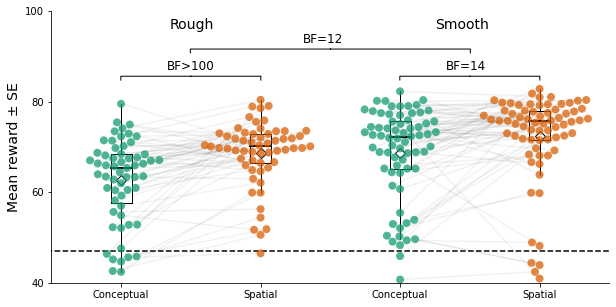

In [14]:
# Boxplot with pyplot
plt.rcParams['figure.figsize'] = [10, 5]
fig, ax = plt.subplots()
plt.ylim((40,100))

plt.boxplot(d, showfliers=False, positions=range(4), widths=[0.15,0.15,0.15,0.15], medianprops={'color': 'black','lw': 2}, showcaps=False)
means = [np.mean(d[0]), np.mean(d[1]), np.mean(d[2]), np.mean(d[3])]
plt.plot([0,1,2,3], means, 'D', lw=0, ms=7, mec="black", mfc="white")

ax.set_yticks([40,60,80,100])

# Swarmplot with seaborn
seaborn.swarmplot(data=data , x="context", y="P_correct", palette=['#159c73','#d95f05'], size=8, alpha=0.75, hue="c")
plt.legend([],[], frameon=False)
seaborn.despine()
plt.ylabel("Mean reward ± SE", fontsize=14)
lines(d, ax, [0,1])
lines(d, ax, [2,3])

ax.text(0.35,96, "Rough", fontsize=14) 
ax.text(2.25,96, "Smooth", fontsize=14)  

ax.text(0.33,87, "BF>100", fontsize=12)  
ax.text(2.33,87, "BF=14", fontsize=12) 
ax.text(1.3,93, "BF=12", fontsize=12)  

ax.annotate('', xy=(0.5, 0.86), xytext=(0.5, 0.861), xycoords='axes fraction', 
            arrowprops=dict(arrowstyle='-[, widthB=14.0, lengthB=0.4', lw=1.0))

ax.annotate('', xy=(0.25, 0.76), xytext=(0.25, 0.761), xycoords='axes fraction', 
            arrowprops=dict(arrowstyle='-[, widthB=7, lengthB=0.4', lw=1.0))

ax.annotate('', xy=(0.75, 0.76), xytext=(0.75, 0.761), xycoords='axes fraction', 
            arrowprops=dict(arrowstyle='-[, widthB=7, lengthB=0.4', lw=1.0))
randomdata = pd.read_csv("rationalModels/random.csv", sep=",")
rndMean = np.mean(randomdata["meanReward"])
plt.plot([-1,100],[rndMean,rndMean], "--", c="black")
plt.show()

In [15]:
d = [[np.mean(x[0:200]) for x in df["zscaled"]], [np.mean(x[200:400]) for x in df["zscaled"]], feature("environment")*2]
rough = [[d[0][i] for i in range(len(d[0])) if d[2][i]==0],[d[1][i] for i in range(len(d[1])) if d[2][i]==0]]
smooth = [[d[0][i] for i in range(len(d[0])) if d[2][i]==1],[d[1][i] for i in range(len(d[1])) if d[2][i]==1]]

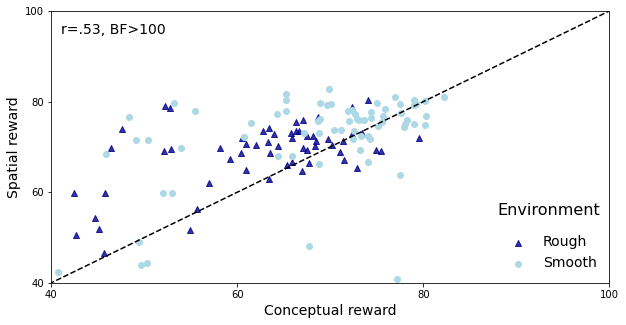

In [16]:
fig, ax = plt.subplots()
plt.xlim((40,100))
plt.ylim((40,100))
ax.set_yticks([40,60,80,100])
ax.set_xticks([40,60,80,100])
plt.xlabel("Conceptual reward", fontsize=14)
plt.ylabel("Spatial reward", fontsize=14)
plt.scatter(rough[1],rough[0], c="darkblue", marker="^", alpha=0.8)
plt.scatter(smooth[1],smooth[0], c="lightblue")
plt.legend(["Rough","Smooth"], loc="lower right", frameon=False, prop={'size': 14})
plt.plot([0,100],[0,100], "--", c="black")
plt.text(88, 55, "Environment", fontsize=16)
plt.text(41,95, "r=.53, BF>100", fontsize=14)

plt.show()

In [17]:
d = [[np.mean(x[0:200]) for x in df["zscaled"]], [np.mean(x[200:400]) for x in df["zscaled"]], feature("contextOrder")*2]
spatial = [[d[0][i] for i in range(len(d[0])) if d[2][i]==0],[d[1][i] for i in range(len(d[1])) if d[2][i]==0]]
conceptual = [[d[0][i] for i in range(len(d[0])) if d[2][i]==1],[d[1][i] for i in range(len(d[1])) if d[2][i]==1]]
d = [conceptual[1], conceptual[0], spatial[1], spatial[0]]
data = {"P_correct": conceptual[1]+conceptual[0]+spatial[1]+spatial[0],
    "context": ["Conceptual"]*len(conceptual[1]) + ["Spatial"]*len(conceptual[0]) + ["ConceptuaI"]*len(spatial[1]) + ["SpatiaI"]*len(spatial[0]),
    "c": ["Conceptual"]*len(conceptual[1]) + ["Spatial"]*len(conceptual[0]) + ["Conceptual"]*len(spatial[1]) + ["Spatial"]*len(spatial[0])}

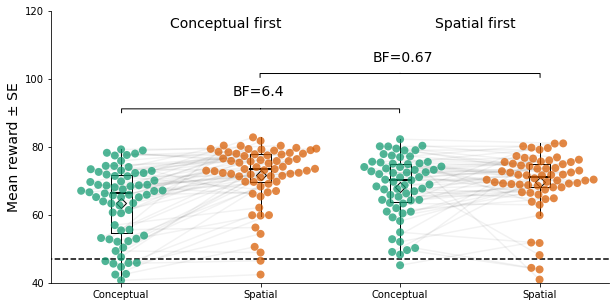

In [18]:
# Boxplot with pyplot
plt.rcParams['figure.figsize'] = [10, 5]
fig, ax = plt.subplots()
plt.ylim((40,120))

plt.boxplot(d, showfliers=False, positions=range(4), widths=[0.15,0.15,0.15,0.15], medianprops={'color': 'black','lw': 2}, showcaps=False)
means = [np.mean(d[0]), np.mean(d[1]), np.mean(d[2]), np.mean(d[3])]
plt.plot([0,1,2,3], means, 'D', lw=0, ms=7, mec="black", mfc="white")

# Swarmplot with seaborn
seaborn.swarmplot(data=data , x="context", y="P_correct", palette=['#159c73','#d95f05'], size=8, alpha=0.75, hue="c")
plt.legend([],[], frameon=False)
seaborn.despine()
plt.ylabel("Mean reward ± SE", fontsize=14)
ax.set_yticks([40,60,80,100,120])
lines(d, ax, [0,1])
lines(d, ax, [2,3])
    
ax.text(0.35,115, "Conceptual first", fontsize=14) 
ax.text(2.25,115, "Spatial first", fontsize=14)  

ax.text(0.8,95, "BF=6.4", fontsize=14)  
ax.text(1.8,105, "BF=0.67", fontsize=14) 

ax.annotate('', xy=(0.375, 0.64), xytext=(0.375, 0.641), xycoords='axes fraction', 
            arrowprops=dict(arrowstyle='-[, widthB=13.9, lengthB=0.4', lw=1.0))

ax.annotate('', xy=(0.625, 0.77), xytext=(0.625, 0.771), xycoords='axes fraction', 
            arrowprops=dict(arrowstyle='-[, widthB=14, lengthB=0.4', lw=1.0))

randomdata = pd.read_csv("rationalModels/random.csv", sep=",")
rndMean = np.mean(randomdata["meanReward"])
plt.plot([-1,100],[rndMean,rndMean], "--", c="black")
plt.show()

In [19]:
d = [[x[0:200] for x in df["zscaled"]], [x[200:400] for x in df["zscaled"]], feature("environment")*2]
smooth = [[d[0][i] for i in range(len(d[0])) if d[2][i]==0],[d[1][i] for i in range(len(d[1])) if d[2][i]==0]]
rough = [[d[0][i] for i in range(len(d[0])) if d[2][i]==1],[d[1][i] for i in range(len(d[1])) if d[2][i]==1]]

def f1(data):
    return np.asmatrix([z for l in [[x[(y)*20:(y+1)*20] for y in range(10)] for x in data] for z in l]).transpose().tolist()

d1 = f1(smooth[0])
d2 = f1(smooth[1])
s = {
    "time": [y for l in [[x]*len(d2[0]) for x in range(20)] for y in l] + [y for l in [[x]*len(d1[0]) for x in range(20)] for y in l],
    "reward": [x for l in d2 for x in l] + [x for l in d1 for x in l],
    "type": ["Conceptual"]*len(d2[0])*20 + ["Spatial"]*len(d1[0])*20
}
d1 = f1(rough[0])
d2 = f1(rough[1])
r = {
    "time": [y for l in [[x]*len(d2[0]) for x in range(20)] for y in l] + [y for l in [[x]*len(d1[0]) for x in range(20)] for y in l],
    "reward": [x for l in d2 for x in l] + [x for l in d1 for x in l],
    "type": ["Conceptual"]*len(d2[0])*20 + ["Spatial"]*len(d1[0])*20
}

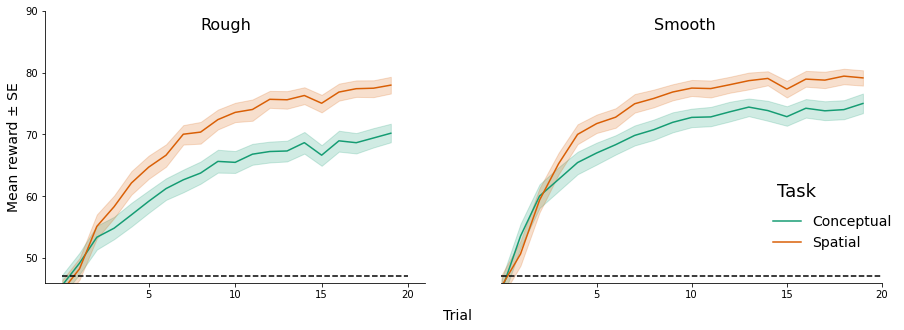

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
axes[1].set_yticks([])
axes[0].set_yticks([50,60,70,80,90])
axes[0].set_xticks([5,10,15,20])
axes[1].set_xticks([5,10,15,20])
plt.ylim((46,90))
plt.xlim((0,20))
axes[0].set_ylabel("Mean reward ± SE", fontsize=14)
seaborn.lineplot(data=s, x="time", y="reward", hue="type", palette=['#159c73','#d95f05'], ax=axes[0])
seaborn.lineplot(data=r, x="time", y="reward", hue="type", palette=['#159c73','#d95f05'], ax=axes[1])
axes[0].legend([],[], frameon=False)
axes[1].legend([],[], frameon=False)
axes[1].legend(["Conceptual","Spatial"], loc=(0.7,0.1), frameon=False, prop={'size': 14})
axes[0].plot([0,20],[rndMean,rndMean], "--", c="black")
axes[1].plot([0,20],[rndMean,rndMean], "--", c="black")
seaborn.despine(bottom = False, left = False, ax=axes[0])
seaborn.despine(bottom = False, ax=axes[1])
axes[1].get_yaxis().set_visible(False)
axes[1].spines["left"].set_visible(False)

axes[0].text(8, 87, "Rough", fontsize=16) 
axes[1].text(8, 87, "Smooth", fontsize=16)  

axes[1].text(14.5, 60, "Task", fontsize=18) 
axes[0].text(22, 40, "Trial", fontsize=14) 

plt.show()

In [21]:
gridSize_1 = 8 #base 1
gridSize_0 = 7 #base 0
uniqueOptions = gridSize_1**2

def rbf(x1,x2,theta):
    #if np.shape(x1)[1] != np.shape(x2)[1]:
    #    print("incorrect x1 and x2 input dimensions")
    #    return
    #elif any([x<0 for x in theta]):
    #    print("all parameters must be greater than 0")
    #    return
    
    N1 = np.shape(x1)[0]
    N2 = np.shape(x2)[0]
    d = np.shape(x1)[1]
    sigma = np.zeros((N1, N2))
    sf = theta[d]
    for i in range(d):
        sigma = sigma + np.matrix((np.subtract.outer(x1[:,i],x2[:,i])/theta[i])**2).T
    if np.array_equal(x1,x2):
        return sf*np.exp(-0.5 * sigma) + theta[d+1]*np.identity(N1)
    else:
        return sf*np.exp(-0.5 * sigma)

In [22]:
def isPositiveDefinite(A):
    if np.allclose(A, A.T):
        try:
            np.linalg.cholesky(A)
            return True
        except np.linalg.LinAlgError:
            return False
    else:
        return False

def gpr(X_test, theta, X, Y, k):
    Xstar = np.matrix(X_test)
    K = k(X, X, theta)
    #if isPositiveDefinite(K):
    #    KK_inv = np.linalg.cholesky(K)
    #else:
    #    KK_inv = np.linalg.pinv(K)
    KK_inv = np.linalg.inv(K)
    Ky = KK_inv.dot(Y.T)
    mus = [0]*np.shape(Xstar)[0]
    sigs = [0]*np.shape(Xstar)[0]
    
    
    for i in range(np.shape(Xstar)[0]):
        XX = Xstar[i]
        Kstar = k(X, XX, theta)
        Kstarstar = k(XX,XX,theta)
        mu = Kstar.T.dot(Ky)
        cv = Kstarstar - (Kstar.T.dot(KK_inv).dot(Kstar))
        if cv < 0:
            cv = abs(cv)
        mus[i] = float(mu)
        sigs[i] = float(cv)
    return pd.DataFrame({"mu": mus, "sig": sigs})

In [23]:
from timeit import default_timer as timer
start = timer()
for i in range(20):
    gpr([[x2, x1] for x1 in range(8) for x2 in range(8)], [0.945098951166948, 0.945098951166948, 1, 0.0001], np.column_stack(([4,1], [5,1])), np.matrix([-0.1577524891006599,-0.1577524891006599]), rbf)
end = timer()
print(end-start)

0.5398540989999674


In [45]:
gpr([[x2, x1] for x1 in range(8) for x2 in range(8)], [0.945098951166948, 0.945098951166948, 1, 0.0001], np.column_stack(([4,1], [5,1])), np.matrix([-0.1577524891006599,-0.1577524891006599]), rbf)

,mu,sig
0,-0.051489,0.893557
1,-0.090121,0.673708
2,-0.051489,0.893557
3,-0.009603,0.996394
4,-0.000585,1.000086
...,...,...
59,-0.009603,0.996394
60,-0.016807,0.988748
61,-0.009603,0.996394
62,-0.001791,0.999971


In [46]:
ucb(gpr([[x2, x1] for x1 in range(8) for x2 in range(8)], [0.945098951166948, 0.945098951166948, 1, 0.0001], np.column_stack(([4,1], [5,1])), np.matrix([-0.1577524891006599,-0.1577524891006599]), rbf), [0.5])

matrix([[4.21151648e-01, 3.20277855e-01, 4.21151634e-01, 4.89495030e-01,
         4.99436847e-01, 5.00013306e-01, 5.00024910e-01, 5.00024998e-01,
         3.20277853e-01, 1.00000000e-04, 3.20275689e-01, 4.80359954e-01,
         4.98970951e-01, 4.99993044e-01, 5.00022701e-01, 5.00024867e-01,
         4.21151516e-01, 3.20271218e-01, 4.21042497e-01, 4.88907078e-01,
         4.98403267e-01, 4.99425360e-01, 4.99915780e-01, 5.00018362e-01,
         4.89492939e-01, 4.80262427e-01, 4.87671945e-01, 4.87671945e-01,
         4.80262427e-01, 4.89492939e-01, 4.98201884e-01, 4.99915855e-01,
         4.99425360e-01, 4.98403267e-01, 4.88907078e-01, 4.21042497e-01,
         3.20271218e-01, 4.21151516e-01, 4.89495104e-01, 4.99436978e-01,
         4.99993044e-01, 4.98970951e-01, 4.80359954e-01, 3.20275689e-01,
         1.00000000e-04, 3.20277853e-01, 4.80371572e-01, 4.98991288e-01,
         5.00013306e-01, 4.99436847e-01, 4.89495030e-01, 4.21151634e-01,
         3.20277855e-01, 4.21151648e-01, 4.89495105

In [24]:
def ucb(out, pars, refactor=False):
    uniqueOptions = 64
    if refactor:
        gamma = pars[0]
        beta_star = pars[1]
        outtotal = (gamma*out["mu"]) + (beta_star*np.sqrt(out["sig"]))
        outtotal[outtotal < 0] = 0.0001
        outtotal[outtotal > 100] = 100
        d1 = round(np.shape(out)[0]/uniqueOptions)
        return np.reshape(int(np.matrix(outtotal)), (int(d1), int(np.sum(np.shape(outtotal))/d1)), order="F")
    else:
        beta = pars[0]
        outtotal = out["mu"] + (beta*np.sqrt(out["sig"]))
        outtotal[outtotal < 0] = 0.0001
        outtotal[outtotal > 100] = 100
        d1 = round(np.shape(out)[0]/uniqueOptions)
        return np.reshape(np.matrix(outtotal), (int(d1), int(np.sum(np.shape(outtotal))/d1)), order="F")

In [25]:
f = open("experiment/roughEnvironment.json")
roughEnvironments = json.load(f)
f.close()
f = open("experiment/smoothEnvironment.json")
smoothEnvironments = json.load(f)
f.close()

gpPars = pd.read_csv("rationalModels/parameters/gpucb.csv", sep=",")

In [26]:
from IPython.display import clear_output

def gprDF(replications=100):
    columns = ["trial", "environment", "context", "meanReward", "meanSE"]
    gprdf = {"trial": [x for x2 in range(4) for x in range(20)],
               "environment": (["Smooth"]*20 + ["Rough"]*20)*2,
               "context": ["Conceptual"]*40 + ["Spatial"]*40,
               "meanReward": np.array([]),
               "meanSE": np.array([])}
    smoothTotal = 0
    roughTotal = 0
    choices = [[x2, x1] for x1 in range(8) for x2 in range(8)]

    for task in ["Conceptual", "Spatial"]:
        smoothPars = gpPars.loc[(gpPars["environment"] == "Smooth") & (gpPars["context"] == task)]
        roughPars = gpPars.loc[(gpPars["environment"] == "Rough") & (gpPars["context"] == task)]
        for x in range(replications):
            # Smooth
            params = smoothPars.iloc[np.random.randint(0,np.shape(smoothPars)[0]),:]
            lam = params["lambda"]
            beta = params["beta"]
            tau = params["tau"]
            envNum = np.random.randint(0,40)
            location = np.random.randint(0,64)
            x1 = [choices[location][0]]
            x2 = [choices[location][1]]
            smoothReward = [[1]]*20
            Y = [smoothEnvironments[str(envNum)][str(location)]["y"]*100]
            smoothReward[0] = Y[0]
            for i in range(19):
                j = i+1
                post = gpr(choices, [lam, lam, 1, 0.0001], np.column_stack((x1, x2)), (np.matrix(Y)-50)/100, rbf)
                utilityVec = ucb(post, [beta])
                utilityVec = utilityVec - np.max(utilityVec)
                p = np.exp(utilityVec/tau)
                p = p/np.sum(p)
                location = np.random.choice(range(64), 1, True, p.tolist()[0])[0]
                smoothReward[j] = smoothEnvironments[str(envNum)][str(location)]["y"]*100
                x1 = x1 + [choices[location][0]]
                x2 = x2 + [choices[location][1]]
                Y = Y + [smoothReward[j]]
            if x == 0 and task == "Conceptual":
                smoothTotal = smoothReward
            else:
                smoothTotal = np.column_stack((smoothTotal, smoothReward))

            # Rough
            params = roughPars.iloc[np.random.randint(0,np.shape(roughPars)[0]),:]
            lam = params["lambda"]
            beta = params["beta"]
            tau = params["tau"]
            envNum = np.random.randint(0,40)
            location = np.random.randint(0,64)
            x1 = [choices[location][0]]
            x2 = [choices[location][1]]
            roughReward = [[1]]*20
            Y = [roughEnvironments[str(envNum)][str(location)]["y"]*100]
            roughReward[0] = Y[0]
            for i in range(19):
                j = i+1
                post = gpr(choices, [lam, lam, 1, 0.0001], np.column_stack((x1, x2)), (np.matrix(Y)-50)/100, rbf)
                utilityVec = ucb(post, [beta])
                utilityVec = utilityVec - np.max(utilityVec)
                p = np.exp(utilityVec/tau)
                p = p/np.sum(p)
                location = np.random.choice(range(64), 1, True, p.tolist()[0])[0]
                roughReward[j] = roughEnvironments[str(envNum)][str(location)]["y"]*100
                x1 = x1 + [choices[location][0]]
                x2 = x2 + [choices[location][1]]
                Y = Y + [roughReward[j]]
            if x == 0 and task == "Conceptual":
                roughTotal = roughReward
            else:
                roughTotal = np.column_stack((roughTotal, roughReward))

            clear_output(wait=True)
            print(task + ": " + str(x+1) + "/" + str(replications))

        if task == "Conceptual":
            gprdf["meanReward"] = np.concatenate((smoothTotal.mean(1), roughTotal.mean(1)))
            gprdf["meanSE"] = np.concatenate((smoothTotal.std(1)/np.sqrt(np.shape(smoothTotal)[0]), roughTotal.std(1)/np.sqrt(np.shape(roughTotal)[0])))
        else:
            gprdf["meanReward"] = np.concatenate((gprdf["meanReward"], smoothTotal.mean(1), roughTotal.mean(1)))
            gprdf["meanSE"] = np.concatenate((gprdf["meanSE"], smoothTotal.std(1)/np.sqrt(np.shape(smoothTotal)[0]), roughTotal.std(1)/np.sqrt(np.shape(roughTotal)[0])))
    return gprdf

In [27]:
start = timer()
gprdf = gprDF(100)
end = timer()
print(end - start)

Spatial: 100/100
291.6750252949996


In [28]:
# Load data obtained from 10,000 simulations
gprdf = pd.read_csv("simulated_data.csv")

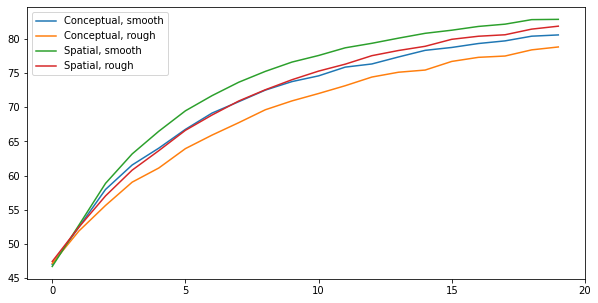

In [29]:
fig, ax = plt.subplots()
plt.plot(range(20), gprdf["meanReward"][0:20])
plt.plot(range(20), gprdf["meanReward"][20:40])
plt.plot(range(20), gprdf["meanReward"][40:60])
plt.plot(range(20), gprdf["meanReward"][60:80])
ax.set_xticks([0, 5, 10, 15, 20])
plt.legend(["Conceptual, smooth", "Conceptual, rough","Spatial, smooth", "Spatial, rough"])
plt.show()

In [99]:
from timeit import default_timer as timer

def modelFit2(par, subjD, rounds, returnPredictions=False):
    tau = np.exp(float(par[0]))
    beta = np.exp(float(par[1]))
    lam = np.exp(float(par[2]))
    parVec = [lam, lam, 1, 0.0001]
    
    Xnew = [[x, y] for y in range(8) for x in range(8)]
    nLL = [0]*len(rounds)
    utilities = None
    for r in rounds:
        roundD = np.array(subjD["round"]) == r
        chosen = np.array(subjD["chosen"])[roundD]
        chosen = chosen[1:20]
        y = np.array(subjD["z"])[roundD]
        y = y[0:20]
        x1 = np.array(subjD["x"])[roundD]
        x1 = x1[0:20]
        x2 = np.array(subjD["y"])[roundD]
        x2 = x2[0:20]
        X = np.column_stack((x1,x2))

        utilities = None
        for i in range(19):
            X1 = np.matrix(X[0:i+1,:])
            y1 = np.matrix(y[0:i+1])
            out = gpr(Xnew, parVec, X1, y1, rbf)
            utilityVec = ucb(out, [beta])
            utilityVec = utilityVec - np.max(utilityVec)
            if i==0:
                utilities = utilityVec
            else:
                utilities = np.row_stack((utilities, utilityVec))
        p = np.exp(utilities / tau)
        p = p / np.sum(p, 1)
        p[p < 0.00001] = 0.00001
        p[p > 0.99999] = 0.99999
        a = [[x, chosen[x]] for x in range(19)]
        nLL[[x for x in range(len(rounds)) if rounds[x]==r][0]] = -np.sum(np.log([p[x[0], x[1]] for x in a]))
        #clear_output(wait=True)
        #print(str(r+1) + "/" + str(len(rounds)))
    if returnPredictions:
        return {"sumLogLoss": np.sum(nLL), "predictions": p, "chosen": chosen}
    else:
        return np.sum(nLL)
    
def modelFit(par, subjD, rounds, returnPredictions=False):
    tau = float(par["tau"])
    lam = float(par["lambda"])
    beta = float(par["beta"])
    return modelFit2([tau, beta, lam], subjD, rounds, returnPredictions)

In [108]:
# Test
modelFit2([0.953290334560277,0.14184440300399,0.0706500217485385], df.iloc[0], [x for x in range(10)], False)

799.150157848398

In [44]:
start = timer()
modelFit2([1,  0.5, 1], df.iloc[0], range(10), False)
end = timer()
print(end - start)

5.026854891999392


In [104]:
import scipy.optimize as sco

def cvfunc(data, task, selector, leaveoutindex):
    d1 = [data.iloc[x] for x in range(len(data)) if data.iloc[x]["id"][0] == selector][0].copy()
    b = [d1["context"][x]==task for x in range(len(d1["context"]))]
    for i in range(len(d1)):
        d1[i] = [d1[i][x] for x in range(len(d1[i])) if b[x]]
        
    rounds = [x for x in range(9)]
    trainingSet = [rounds[x] for x in range(len(rounds)) if x != leaveoutindex]
    testSet = rounds[leaveoutindex]
    bounds = [(-5,5),(-5,5),(-5,5)]
    # updating="immediate", strategy="best1bin"
    fit = sco.differential_evolution(modelFit2, bounds, (d1, trainingSet, False), disp=True, maxiter=20)
    paramEstimates = fit.x
    print(fit)
    
    
    predict = modelFit2(paramEstimates, d1, [testSet], True)
    cvresults = {"loo": leaveoutindex, "nLL": predict["sumLogLoss"], "tau": paramEstimates[0], "lambda": paramEstimates[1], "beta": paramEstimates[2]}
    return [cvresults, predict["predictions"], predict["chosen"]]

In [38]:
# For testing purposes
def modelFit3(data, pars, task, selector, leaveoutindex):
    d1 = [data.iloc[x] for x in range(len(data)) if data.iloc[x]["id"][0] == selector][0].copy()
    b = [d1["context"][x]==task for x in range(len(d1["context"]))]
    for i in range(len(d1)):
        d1[i] = [d1[i][x] for x in range(len(d1[i])) if b[x]]
    
    rounds = [x for x in range(9)]
    trainingSet = [rounds[x] for x in range(len(rounds)) if x != leaveoutindex]
    print(modelFit2(pars, d1, trainingSet, False))

In [39]:
modelFit3(df, [1.02320515632445,0.110314130468726,0.0676485720434532], "Spatial", 1, 0)

459.04588902143433


In [105]:
start = timer()
cv = cvfunc(df, "Spatial", 1, 0)
end = timer()
print(end - start)

differential_evolution step 1: f(x)= 420.904
differential_evolution step 2: f(x)= 420.904
differential_evolution step 3: f(x)= 395.331
differential_evolution step 4: f(x)= 383.432
differential_evolution step 5: f(x)= 383.432
differential_evolution step 6: f(x)= 383.432
differential_evolution step 7: f(x)= 383.432
differential_evolution step 8: f(x)= 382.109
differential_evolution step 9: f(x)= 382.109
differential_evolution step 10: f(x)= 381.774
differential_evolution step 11: f(x)= 381.774
differential_evolution step 12: f(x)= 381.016
differential_evolution step 13: f(x)= 380.926
     fun: 380.7410337600927
     jac: array([-0.01267608,  0.0223622 , -0.05842935])
 message: 'Optimization terminated successfully.'
    nfev: 746
     nit: 13
 success: True
       x: array([-2.69348409, -2.20437827,  0.02296126])
4313.175159724


In [116]:
# Same result as in the original paper
np.exp([-2.69348409, -2.20437827,  0.02296126])

array([0.06764485, 0.11031909, 1.0232269 ])

In [65]:
# Cross validation
start = timer()

crossvalidation = [0]*9
modelPrediction = [np.zeros((19,64)) for x in range(9)]
chosenMatrix = np.zeros((9,19))

print("0/9")
for loo in range(9):
    cv = cvfunc(data=df, task="Conceptual", selector = 1, leaveoutindex=loo)
    crossvalidation[loo] = cv[0]
    modelPrediction[loo] = cv[1]
    chosenMatrix[loo,:] = cv[2]
    clear_output(wait=True)
    print(str(loo+1) + "/9")
end = timer()
print(end - start)

9/9
14024.757741057998


In [66]:
print(crossvalidation)

[{'loo': 0, 'nLL': 64.69578615321979, 'tau': -1.7359799346259148, 'lambda': 1.2526199792066952, 'beta': 2.816470433741199}, {'loo': 1, 'nLL': 53.25192536013484, 'tau': -1.514800608581477, 'lambda': 1.0510893139426847, 'beta': -1.5199827375408197}, {'loo': 2, 'nLL': 53.63567414607466, 'tau': -1.4809955471101384, 'lambda': 1.0289185606200715, 'beta': 0.3203988646542033}, {'loo': 3, 'nLL': 54.106591870775375, 'tau': -1.4681311857985988, 'lambda': 1.0472333021121056, 'beta': 0.11875721084958935}, {'loo': 4, 'nLL': 51.62553544067555, 'tau': -1.4442281513708581, 'lambda': 0.9718984196096366, 'beta': 2.490497801174365}, {'loo': 5, 'nLL': 55.648868256320476, 'tau': -1.508485452508975, 'lambda': 1.044129880935834, 'beta': -1.393809405923524}, {'loo': 6, 'nLL': 52.444721066050434, 'tau': -1.462763140519846, 'lambda': 1.0472344877805342, 'beta': -2.464177746122756}, {'loo': 7, 'nLL': 50.860244403557935, 'tau': -1.4286421661134918, 'lambda': 1.047241242497942, 'beta': -3.3774076254259127}, {'loo':